In [1]:
import cv2
import openslide
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import pytz
import datetime
import os
import tifffile as tiff

In [2]:
# 현재 시각
kst = pytz.timezone('Asia/Seoul')
current_datetime = datetime.datetime.now(kst)
day = current_datetime.strftime("%Y_%m_%d")
hour = current_datetime.strftime("%I:%M_%p")
print(day, hour)

2023_06_21 05:45_PM


In [3]:
output_path = f"git_ignore/output/{day}"
figure_path = f"{output_path}/figure"

In [4]:
# 이미지 불러오기
predict = cv2.imread(r'git_ignore/output/2023_06_21/figure/test_segmentation_1024(10x).tiff')
answer = cv2.imread(r'git_ignore/output/answer_segmentation.tiff')


In [5]:
slide = openslide.OpenSlide("git_ignore/PDA_svs_img/C3L-01637-21.svs")
slide_arr = np.array(slide.read_region((0,0), 0, slide.level_dimensions[0]).convert("RGB")).astype(np.uint8)
slide_arr.shape

(12960, 15935, 3)

In [6]:
pred_label = ((predict - (0.7*slide_arr).astype(np.uint8)[...,::-1])/0.3).astype(np.uint8)
pred_label = ((pred_label!=0)).astype(np.uint8)

In [7]:
answer_label = ((answer - (0.7*slide_arr).astype(np.uint8)[...,::-1])/0.3).astype(np.uint8)
answer_label = ((answer_label!=0)).astype(np.uint8)

In [8]:
def mask_apply (image, label1, label2):
    mask1 = label1 > 0
    mask1 = mask1.astype(np.uint8)
    mask2 = label2 > 0
    mask2 = mask2.astype(np.uint8)

    mask1_rest = mask1 - mask2
    mask2_rest = mask2 - mask1
    overlap = cv2.bitwise_and(mask1, mask2)
    
    mask1_rest_rgb = (mask1_rest * [0, 0, 255]).astype(np.uint8) # answer = blue
    mask2_rest_rgb = (mask2_rest * [255,  0,  0]).astype(np.uint8) # predict = red
    overlab_rgb = (overlap * [29,  177,  76]).astype(np.uint8) # overlab = green

    
    # mask가 적용된 부분은 마스크로 계산합니다.
    masked_image1 = cv2.multiply(image, mask1_rest).astype(np.uint8)
    masked_image1 = cv2.addWeighted(masked_image1, 0.2, mask1_rest_rgb, 0.8, 0)
    masked_image2 = cv2.multiply(image, mask2_rest).astype(np.uint8)
    masked_image2 = cv2.addWeighted(masked_image2, 0.2, mask2_rest_rgb, 0.8, 0)
    masked_image3 = cv2.multiply(image, overlap).astype(np.uint8)
    masked_image3 = cv2.addWeighted(masked_image3, 0.2, overlab_rgb, 0.8, 0)


    # 이미지 합성
    result = cv2.add(masked_image1, masked_image2)
    result = cv2.add(result, masked_image3)

    # mask가 적용되지 않은 부분은 원본 이미지에서 가져옵니다.
    mask3 = label1 == 0
    mask4 = label2 == 0
    mask3 = mask3.astype(np.uint8)
    mask4 = mask4.astype(np.uint8)
    masked_image3 = cv2.multiply(image, mask3)
    masked_image4 = cv2.multiply(masked_image3, mask4)
    
    # mask가 적용된 부분과 mask가 적용되지 않은 부분을 합성합니다.
    result_image = cv2.add(result, masked_image4)
    return result_image

In [9]:
result = mask_apply(slide_arr, answer_label, pred_label).astype(np.uint8)

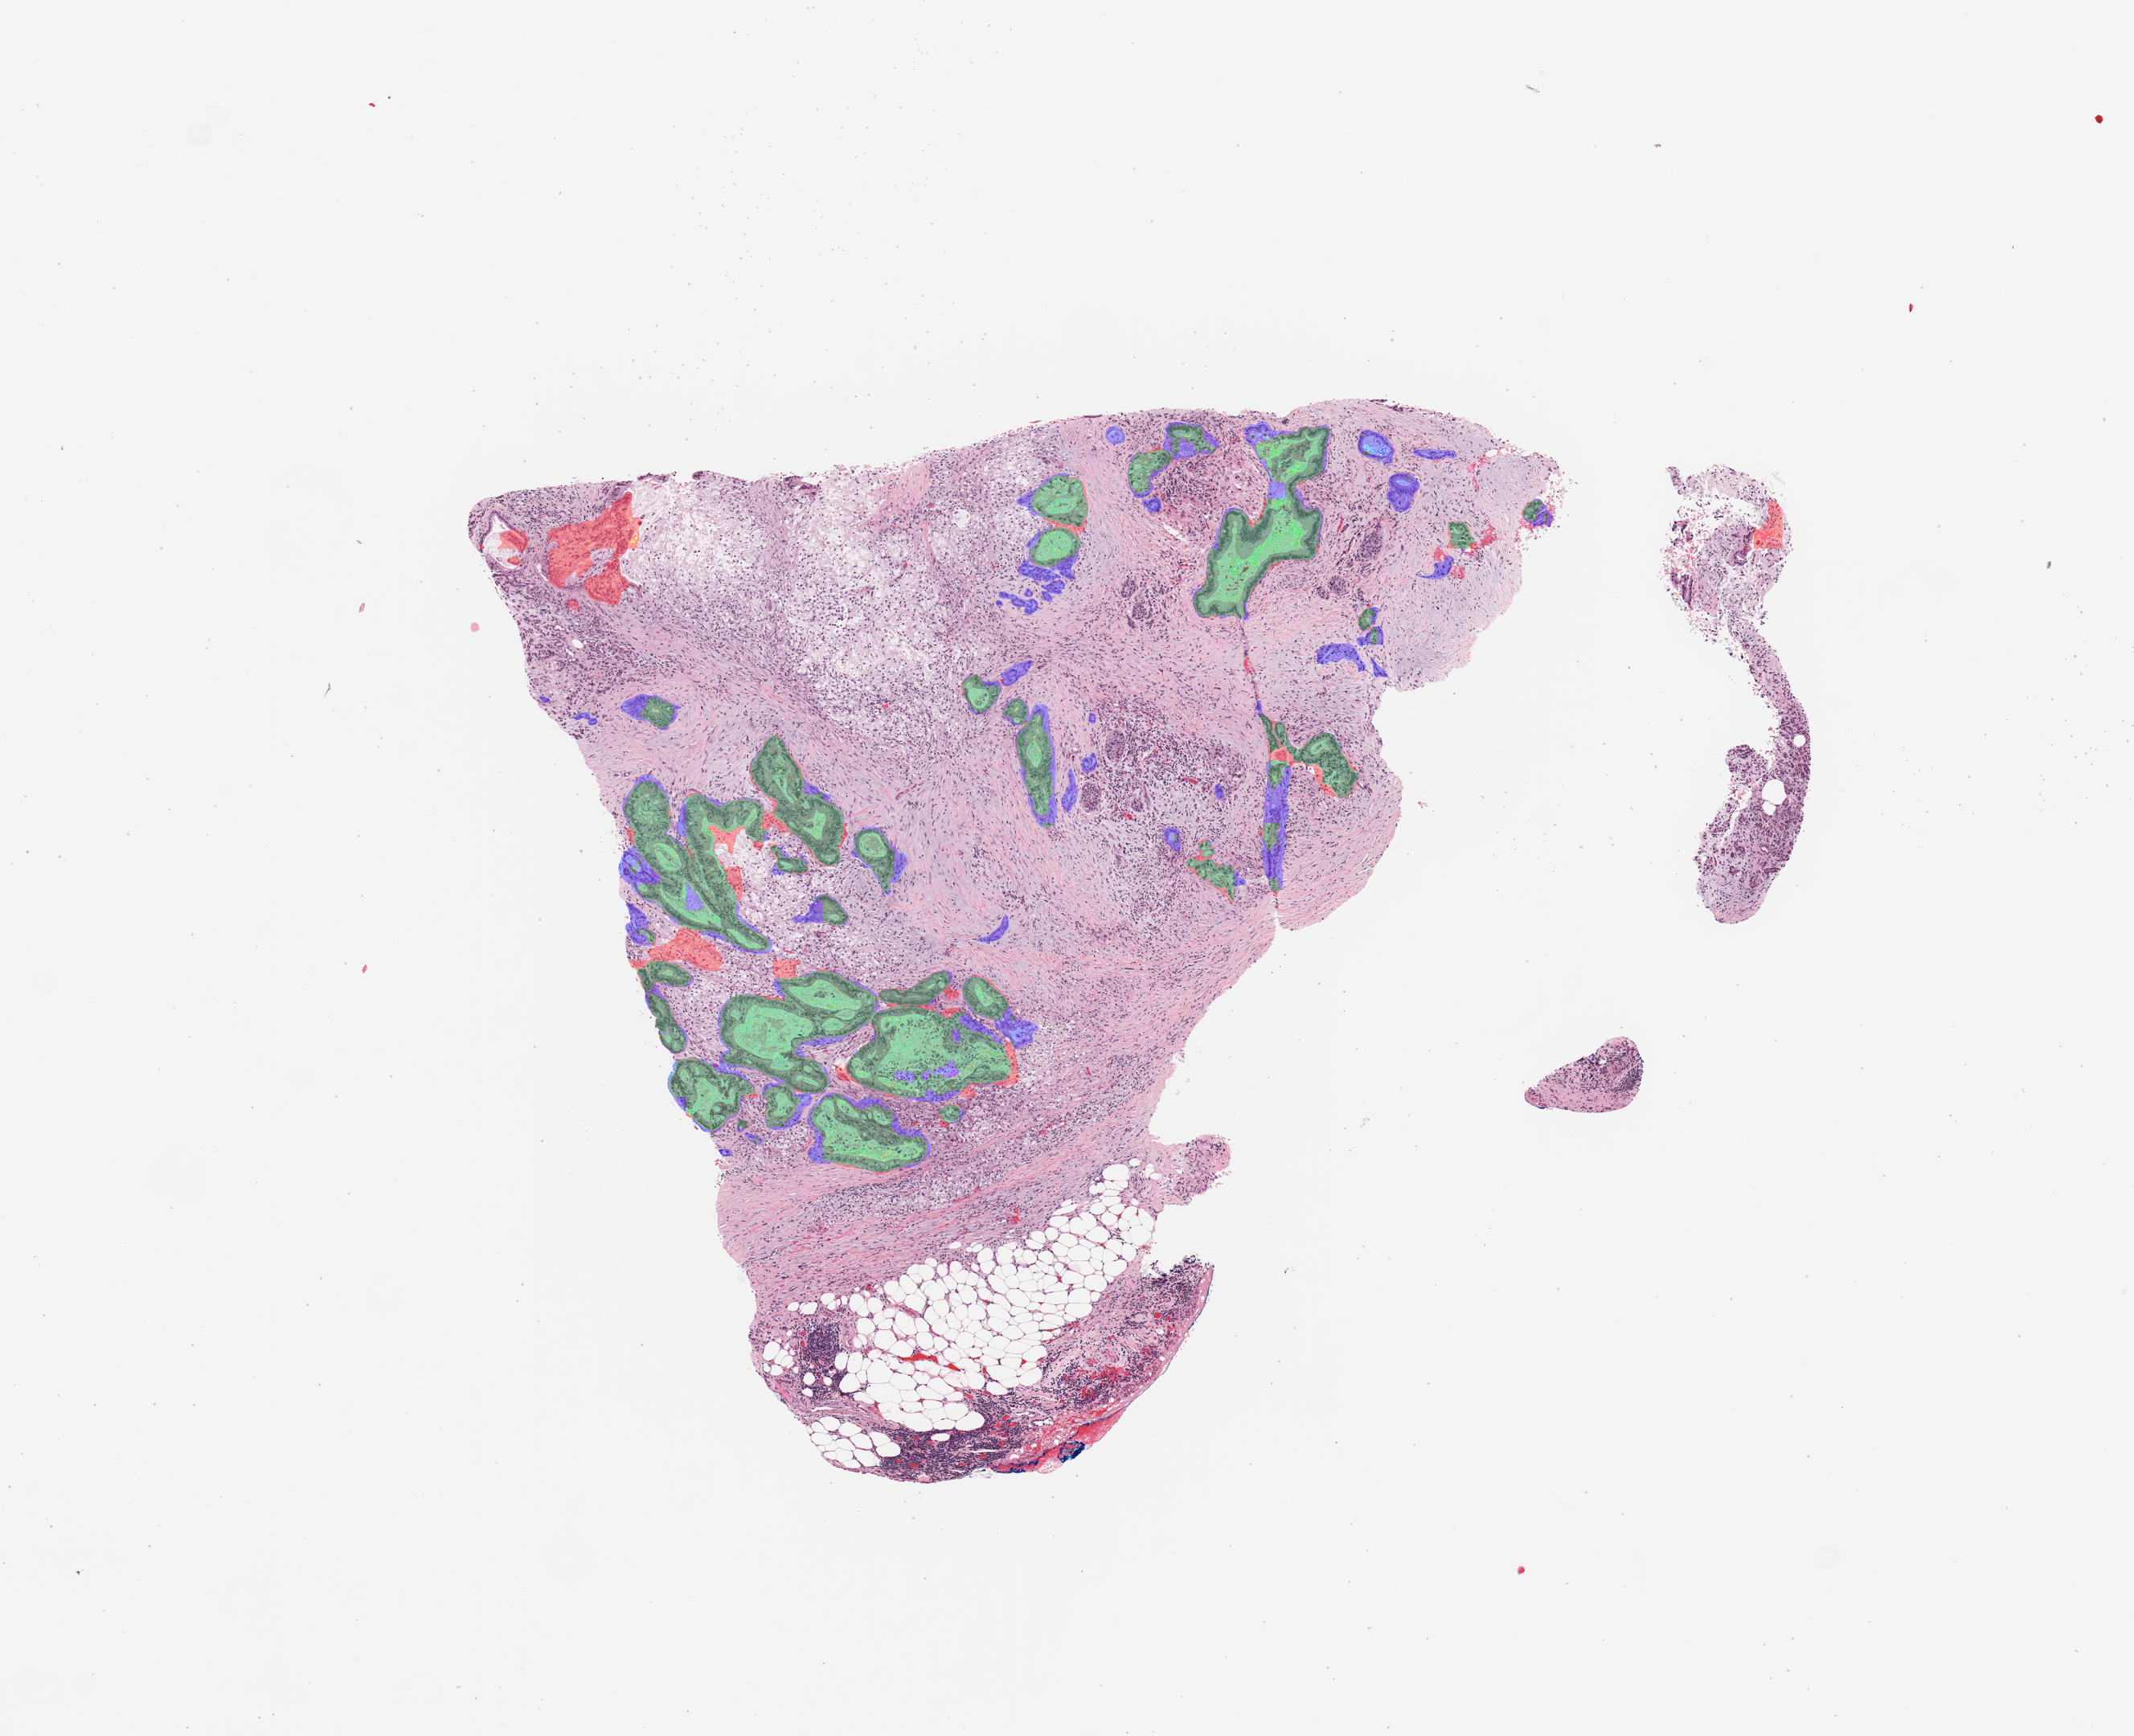

In [10]:
# answer = blue
# predict = red
# overlab = green
result_img = Image.fromarray(result)
resize_image = result_img.resize((int(result_img.width / 6), int(result_img.height / 6)))
resize_image


In [11]:
# save
# os.makedirs(f"{figure_path}", exist_ok=True)
# tiff.imsave(f"{figure_path}/overlab_1024(10x).tiff",result)

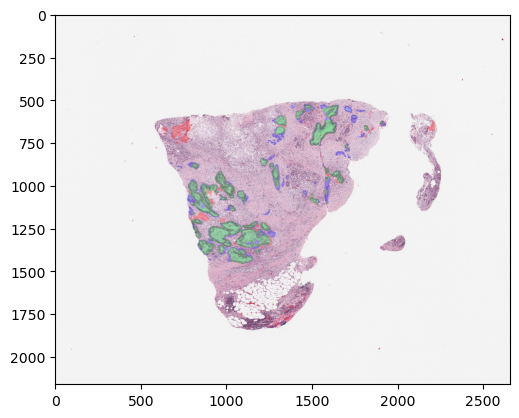

In [12]:
plt.imshow(resize_image)